In [1]:
import os
# AIX環境での proxy の設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import keras
from keras.preprocessing import image

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.
using GPU: 1


In [4]:
# VGG16を使った特徴抽出．
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
input_tensor = Input(shape=(in_size, in_size, 3))
base_model = MobileNet(include_top=False, weights='imagenet',input_tensor=input_tensor)
# fc2の出力を model の出力として定義します．


NameError: name 'Input' is not defined

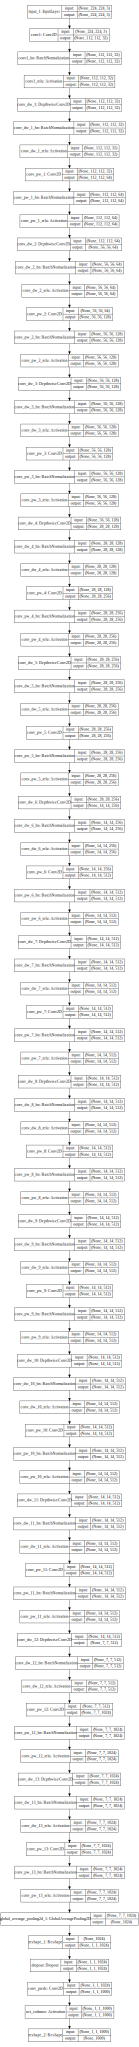

In [3]:
# VGG16 の表示
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(base_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [5]:
import glob
# imglist に 10クラス1000枚を読み込みます．
# cat dog elephant fish horse lion penguin tiger whale wildcat があります．
#imglist=glob.glob('animal/*/*.jpg')
#imglist=glob.glob('material10/*/*.jpg')
#imglist=glob.glob('uecfood10/*/*.jpg')
imglist=glob.glob('uecfood20/*/*.jpg')
n_class=20
num_per_class=100
num=num_per_class*n_class

# 1000枚画像をimgsに読み込みます．
in_size=224
imgs = np.empty((0,in_size,in_size,3), int)
for i, img_path in enumerate(imglist):
  if i%100==0:
    print("reading {}th image".format(i))
  img = image.load_img(img_path, target_size=(in_size, in_size))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  imgs = np.vstack((imgs,x))
print(imgs.shape)


reading 0th image
reading 100th image
reading 200th image
reading 300th image
reading 400th image
reading 500th image
reading 600th image
reading 700th image
reading 800th image
reading 900th image
reading 1000th image
reading 1100th image
reading 1200th image
reading 1300th image
reading 1400th image
reading 1500th image
reading 1600th image
reading 1700th image
reading 1800th image
reading 1900th image
(2000, 224, 224, 3)


In [6]:
label=np.empty((0),int)
for i in range(n_class):
  label=np.append(label,i*np.ones(num_per_class,dtype=np.int))

# indexの作成．10で割ってf余る数がtestのindex, そうでない数がtrainのindex.
for f in range(5):
    train=[n for n in range(num) if n%10!=f]
    test =[n for n in range(num) if n%10==f]

# 1 of Kのベクトルに変換
Y_train = keras.utils.to_categorical(label[train], n_class)
Y_test = keras.utils.to_categorical(label[test], n_class)

X_train = imgs[train]
X_test =imgs[test]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input, Dropout

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model

# VGG16の読み込み．FC層は不要なので include_top=False
input_tensor = Input(shape=(in_size, in_size, 3))
mobilenet = MobileNet(include_top=False, weights='imagenet',input_tensor=input_tensor)
SVG(model_to_dot(mobilenet, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [7]:
#VGG16 finetuning
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input, Dropout

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model

# VGG16の読み込み．FC層は不要なので include_top=False
input_tensor = Input(shape=(in_size, in_size, 3))
mobilenet = MobileNet(include_top=False, weights='imagenet',input_tensor=input_tensor)

# FC層の作成 最終層のエレメント数はクラス数と同じ
top_model = Sequential()
top_model.add(Flatten(input_shape=mobilenet.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_class, activation='softmax'))

# VGG16とFC層を結合してモデルを作成
mobilenet_model = Model(inputs=input_tensor, outputs=top_model(mobilenet.output))

# 最後のconv層の直前までの層をfreeze
for layer in mobilenet_model.layers[:88]:
    layer.trainable = False

# モデルのcompile. fine-tunining時は学習率は小さめにする．lr=0.0001 とする．
vgg_model.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9),
#          optimizer=keras.optimizers.Adam(),
          metrics=['accuracy'])

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
# callback のクラス ShowGraphを定義
class ShowGraph(keras.callbacks.Callback):
    def __init__(self,max_epoch):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0.5, 1.0])
        self.fig1.set_title('accuracy')
        self.fig1.set_ylabel('accuracy')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([0, max_epoch, 0, 5])
        self.fig2.set_title('loss')
        self.fig2.set_ylabel('loss')
        self.fig2.set_xlabel('epoch')
        self.max_epoch=max_epoch
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.losses_val=[]
        self.acc=[]
        self.acc_val=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, logs={}):
        self.n_epoch.append(epoch)
        self.acc.append(logs.get('acc'))
        self.acc_val.append(logs.get('val_acc'))     
        self.losses.append(logs.get('loss'))
        self.losses_val.append(logs.get('val_loss'))     
        self.test_acc=logs.get('val_acc')
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
        self.fig1.plot(self.n_epoch,self.acc_val,"r")
        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
        self.fig2.plot(self.n_epoch,self.losses_val,"r")
        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
        
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val acc値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("val_acc: ",self.test_acc) 
        print('Time: ',time.time()-self.start)

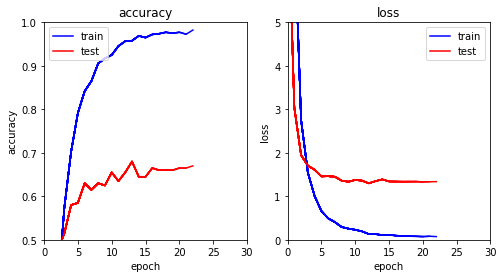

In [ ]:
num_epoch=30
show_graph=ShowGraph(num_epoch)
reduce_lr =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.00001)
vgg_model.fit(X_train, Y_train, epochs=num_epoch+1, validation_data=(X_test,Y_test), batch_size=64, verbose=0, 
              callbacks=[show_graph, reduce_lr])
del show_graph

### 課題4

以下の小問の(1)-(2)を解答すること．(3)は任意（できるだけやってみる方が望ましい．）．

1. ResNet50, Xception, MobileNetで，3枚以上の画像について，それぞれ1000種類認識を行うこと．
1. 上記のデータセットで，VGG16をfine-tuningして，画像分類を行うこと．
1. (2)と同様に, MobileNet, Xception, ResNet50など，別のネットワークで fine-tuningして，学習時間と精度を比較せよ．

(2), (3)は以下のデータセットのどれかを利用すること．UEC-Food20 のみ20種類で，あとは10種類です．すべて1クラス100枚ずつ入っています．  
（自分で用意可能な人は，自分で用意したものを利用してもよい．各カテゴリ100枚10クラス以上用意せよ．）

 * UEC-Food20 http://mm.cs.uec.ac.jp/uecfood20.zip
 * UEC-Food10 http://mm.cs.uec.ac.jp/uecfood10.zip (上記の10種類版．メモリが足りない場合にどうぞ．)
 * FlickrMaterialDatabase(FMD) http://mm.cs.uec.ac.jp/material10.zip


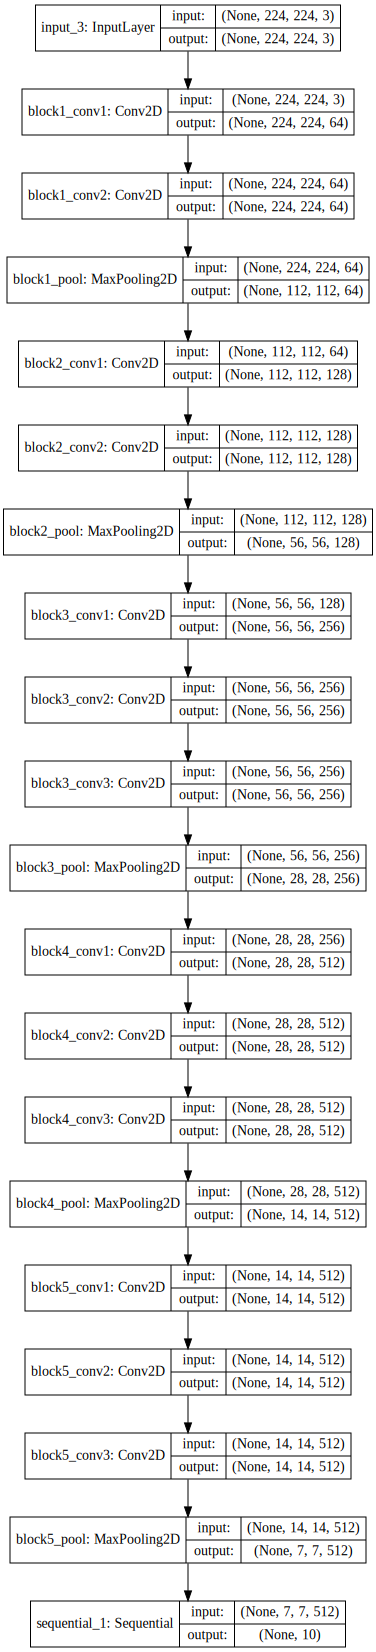

In [14]:
SVG(model_to_dot(vgg_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

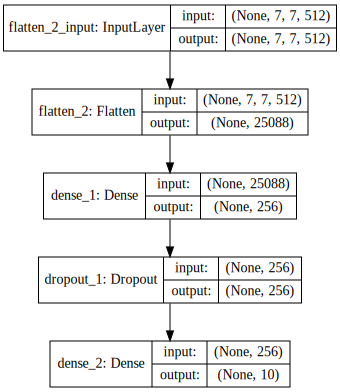

In [15]:
SVG(model_to_dot(top_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))